AO3 analysis: correlations
==============

This notebook presents the code used to generate the plots in [post 4]() of [my series on Archive of Our Own metadata]().  The underlying database is not, and will not be, public, but the code here can be reused by others with similar plotting needs.

This particular post discusses how the top tags, ratings, etc on the AO3 correlate with each other.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import graph_tool.all as gt
import plotly.offline as py
import plotly.graph_objs as go

from ao3db import ao3db
from utils import format_tag, correlate, cross_correlate, reorder_array, write_dataframe, get_topten_fandoms

py.init_notebook_mode(connected=True)


In [2]:
# Some settings that will help us make pretty plots
sns.set(style='whitegrid')
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Lucida Grande']
rcParams['font.size'] = 18
rcParams['axes.labelsize'] = 18
rcParams['axes.titlesize'] = 22
rcParams['axes.titleweight'] = 'normal'
rcParams['axes.labelpad'] = 20
rcParams['axes.labelcolor'] = 'gray'
rcParams['figure.figsize'] = (12.0, 8.0)
rcParams['legend.fontsize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
figsize = plt.gcf().get_size_inches()
cmap = plt.get_cmap("viridis")
single_color = sns.color_palette('dark')[2]

<Figure size 864x576 with 0 Axes>

In [3]:
db = ao3db()

First up: correlations between the top tags.  Let's remake our top tags, top character tags, and top relationship tags from the previous post.  

In [4]:
# We'll pull all the tag data & associate it with a number of hits.
# Sometimes a work is tagged with two tags that mean the same thing--let's get rid of those duplicates.
data = db.get_data('TagName', 'ID', duplicates=False)
warnings = db.get_data("TagName", "TagCategory", conditions=["TagCategory IS 'warnings'"]).drop_duplicates()
not_warnings = data[~data["TagName"].isin(warnings["TagName"])]
not_warnings['ID'] = not_warnings['ID']%1000000000
nworks = len(not_warnings['ID'].unique())
print(nworks, "nworks")
# These are URL-formatted tags. Let's reformat the TagName field to be prettier.
data['TagName'] = data['TagName'].map(format_tag)
tag_counts = data['TagName'].value_counts()

canonical_tags = db.get_data('TagName', 'TagCategory')
canonical_tags['TagName'] = canonical_tags['TagName'].map(format_tag)
canonical_tags = canonical_tags.drop_duplicates()

characters = canonical_tags.query("TagCategory == 'character'")
character_tag_counts = tag_counts.loc[tag_counts.index.isin(characters['TagName'])].sort_values(ascending=False)
top_character_tags = list(character_tag_counts.index[:12])
top_character_tags.remove("Original Female Character(S)")
top_character_tags.remove("Original Characters")

relationships = canonical_tags.query("TagCategory == 'relationship'")
relationship_tag_counts = tag_counts.loc[tag_counts.index.isin(relationships['TagName'])].sort_values(ascending=False)
top_relationship_tags = relationship_tag_counts.index[:10]

freeform = canonical_tags.query("TagCategory == 'free'")
freeform_tag_counts = tag_counts.loc[tag_counts.index.isin(freeform['TagName'])].sort_values(ascending=False)
top_tags = freeform_tag_counts.index[:10]
plot_top_tags = list(freeform_tag_counts.index[:101]) # for later
if 'Original Character(S)' in plot_top_tags:
    plot_top_tags.remove('Original Character(S)')
else:
    plot_top_tags = plot_top_tags[:100]
plot_top_tags_pretty = plot_top_tags[:]
if "I'M Sorry" in plot_top_tags_pretty:
    plot_top_tags_pretty[plot_top_tags_pretty.index("I'M Sorry")] = "I'm Sorry"
if "Post-Traumatic Stress Disorder - Ptsd" in plot_top_tags_pretty:
    plot_top_tags_pretty[plot_top_tags_pretty.index(
        "Post-Traumatic Stress Disorder - Ptsd")] = "Post-Traumatic Stress Disorder - PTSD"

/home/msimet/software/anaconda2/envs/graph-tool/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



4336340 nworks


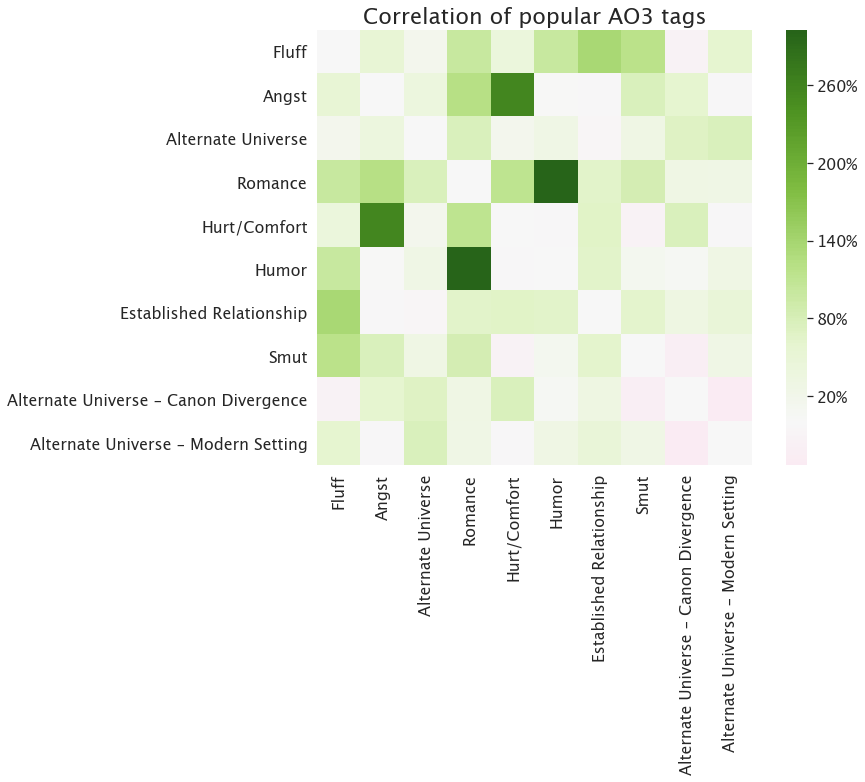

In [5]:
fig, ax = plt.subplots()
data_top_tags = data.loc[data["TagName"].isin(top_tags)]
indices, heatmap_matrix, norm_heatmap_matrix = correlate(data_top_tags, "TagName", nworks=nworks)
norm_heatmap_matrix = reorder_array(norm_heatmap_matrix, indices, top_tags)
#sns.heatmap(np.log10(norm_heatmap_matrix), xticklabels=top_tags, yticklabels=top_tags, ax=ax, cmap='PiYG', center=0)
sns.heatmap(norm_heatmap_matrix, xticklabels=top_tags, yticklabels=top_tags, ax=ax, cmap='PiYG', center=1)
ax.set_aspect('equal')
cbar = ax.figure.get_axes()[1]
vals = cbar.get_yticks()
cbar.yaxis.set_ticklabels(['{:,.0%}'.format((x-1)) for x in vals])
ax.set_title("Correlation of popular AO3 tags")
fig.savefig("tag_heatmap.png")

Next up: pairing type autocorrelation.

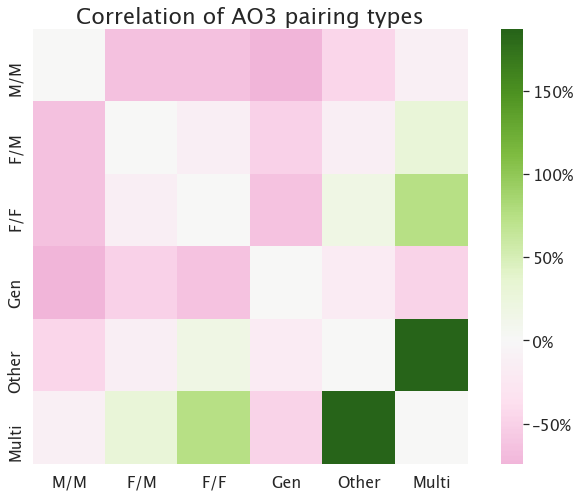

In [6]:
pairing_data = db.get_data('PairingType', 'ID')
pairing_data = pairing_data.query("PairingType != 'No category'")
pairing_types = ['M/M', 'F/M', 'F/F', 'Gen', 'Other', 'Multi']
for pt in pairing_types:
    pairing_data[pt] = pairing_data['PairingType'].str.contains(pt)
pairing_data = pairing_data.drop("PairingType", axis=1)

indices, heatmap_matrix, norm_heatmap_matrix = correlate(pairing_data.drop('ID', axis=1), "PairingType", 
                                                         pivot=False, nworks=nworks)
fig, ax = plt.subplots()
sns.heatmap(norm_heatmap_matrix, xticklabels=indices, yticklabels=indices, ax=ax, center=1, cmap="PiYG")
ax.set_aspect('equal')
cbar = ax.figure.get_axes()[1]
vals = cbar.get_yticks()
cbar.yaxis.set_ticklabels(['{:,.0%}'.format((x-1)) for x in vals])
ax.set_title("Correlation of AO3 pairing types")
fig.savefig("pairingtype_heatmap.png")

Now for the fun stuff: cross-correlations! Do ratings and tags correlate?

In [7]:
ratings_data = db.get_data('Rating', "ID")
# For some unknown reason, one (1) work in my database has this rating. I don't know either.
ratings_data.loc[ratings_data['Rating']=="Teen And Up Audiences, Not Rated", 'Rating'] = u"Teen And Up Audiences"
# "No rating" is basically NaN, a processing failure.
ratings_data = ratings_data.query('Rating != "No rating"')

['Explicit', 'Explicit, Mature', 'Explicit, Not Rated', 'General Audiences', 'General Audiences, Not Rated', 'General Audiences, Teen And Up Audiences', 'Mature', 'Mature, Explicit', 'Mature, Not Rated', 'Mature, Teen And Up Audiences', 'Not Rated', 'Not Rated, General Audiences', 'Not Rated, Mature', 'Not Rated, Teen And Up Audiences', 'Teen And Up Audiences', 'Teen And Up Audiences, General Audiences', 'Teen And Up Audiences, Mature']


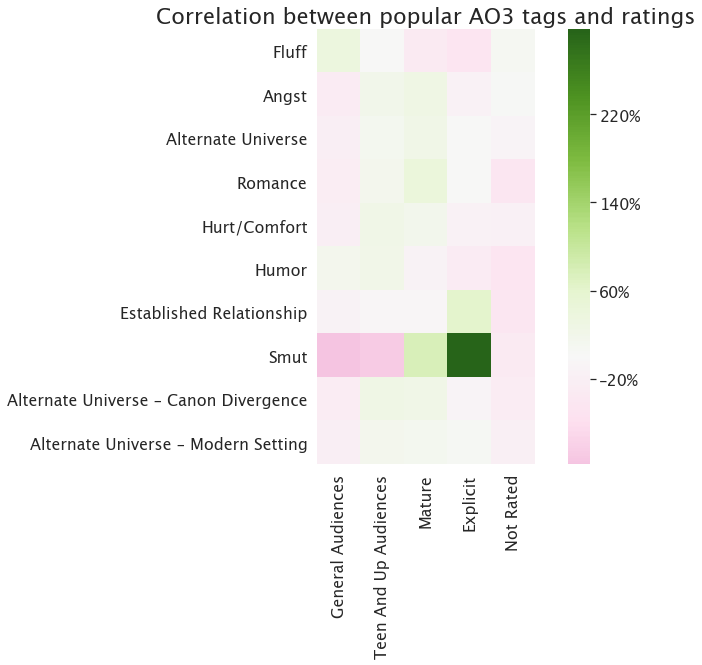

In [8]:
new_ratings_index = ["General Audiences", "Teen And Up Audiences", "Mature", "Explicit", "Not Rated"]
fig, ax = plt.subplots()#gridspec_kw={'left': 0.3, 'bottom': 0.3})
ratings_index, tags_index, heat_matrix, norm_heat_matrix = cross_correlate(
    ratings_data, "Rating", data_top_tags, "TagName", pivot=True, nworks=nworks)
print(ratings_index)
norm_heat_matrix = reorder_array(norm_heat_matrix, ratings_index, new_ratings_index, axis="x")
norm_heat_matrix = reorder_array(norm_heat_matrix, tags_index, top_tags, axis='y')
#sns.heatmap(np.log10(norm_heat_matrix), xticklabels=new_ratings_index, yticklabels=top_tags, ax=ax, center=0, cmap="PiYG")
sns.heatmap((norm_heat_matrix), xticklabels=new_ratings_index, yticklabels=top_tags, ax=ax, center=1, cmap="PiYG")
ax.set_aspect('equal')
cbar = ax.figure.get_axes()[1]
vals = cbar.get_yticks()
cbar.yaxis.set_ticklabels(['{:,.0%}'.format((x-1)) for x in vals])
ax.set_title("Correlation between popular AO3 tags and ratings")
fig.savefig("ratings_tags_crosscorrelation.png")

Tags and pairing type?

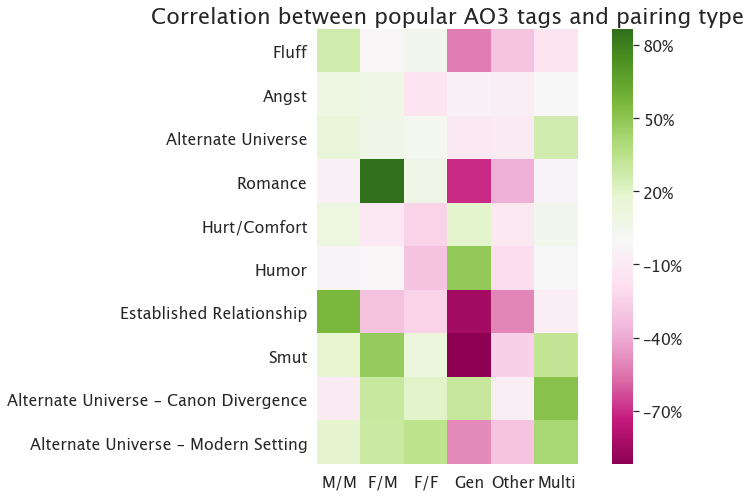

In [9]:
fig, ax = plt.subplots()
pairing_type_index, tags_index, heat_matrix, norm_heat_matrix = cross_correlate(
    pairing_data, "PairingType", data_top_tags, "TagName", pivot=[False, True], nworks=nworks)
norm_heat_matrix = reorder_array(norm_heat_matrix, tags_index, top_tags, axis='y')
#sns.heatmap(np.log10(norm_heat_matrix), xticklabels=pairing_type_index, yticklabels=top_tags, ax=ax, center=0, cmap='PiYG')
sns.heatmap((norm_heat_matrix), xticklabels=pairing_type_index, yticklabels=top_tags, ax=ax, center=1, cmap='PiYG')
ax.set_aspect('equal')
cbar = ax.figure.get_axes()[1]
vals = cbar.get_yticks()
cbar.yaxis.set_ticklabels(['{:,.0%}'.format((x-1)) for x in vals])
ax.set_title("Correlation between popular AO3 tags and pairing type")
fig.savefig("tags_pairingtype_crosscorrelation.png")

Ratings and pairing type?

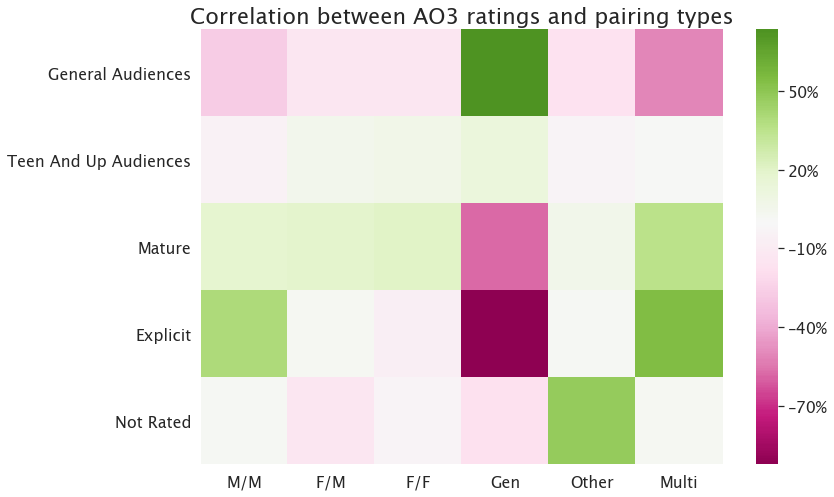

In [10]:
fig, ax = plt.subplots()
pairing_type_index, ratings_index, heat_matrix, norm_heat_matrix = cross_correlate(
    pairing_data, "PairingType", ratings_data, "Rating", pivot=[False, True], nworks=nworks)
norm_heat_matrix = reorder_array(norm_heat_matrix, ratings_index, new_ratings_index, axis="y")
#sns.heatmap(np.log10(norm_heat_matrix), xticklabels=pairing_type_index, yticklabels=new_ratings_index, ax=ax, center=0, cmap='PiYG')
sns.heatmap((norm_heat_matrix), xticklabels=pairing_type_index, yticklabels=new_ratings_index, ax=ax, center=1, cmap='PiYG')
ax.set_aspect('equal')
cbar = ax.figure.get_axes()[1]
vals = cbar.get_yticks()
cbar.yaxis.set_ticklabels(['{:,.0%}'.format((x-1)) for x in vals])
ax.set_title("Correlation between AO3 ratings and pairing types")
fig.savefig("ratings_pairingtype_crosscorrelation.png")

Ratings and relationship tags?

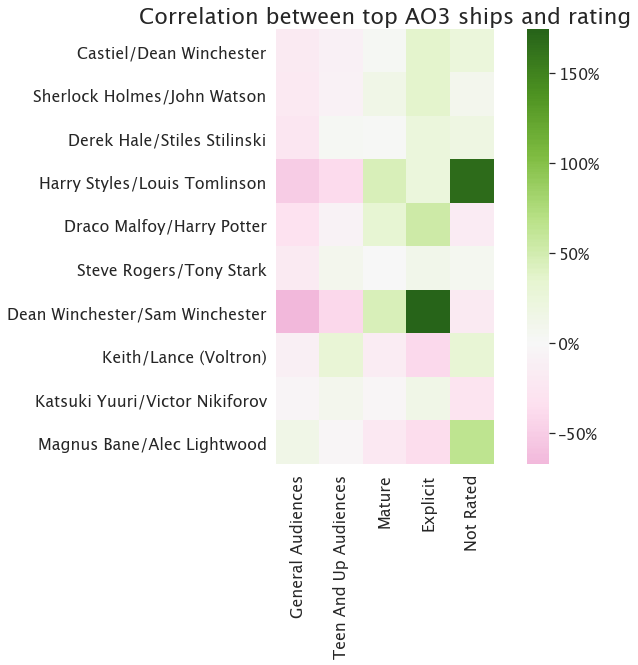

In [11]:
data_top_relationship_tags = data.loc[data["TagName"].isin(top_relationship_tags)]

fig, ax = plt.subplots()
ratings_index, tags_index, heat_matrix, norm_heat_matrix = cross_correlate(
    ratings_data, "Rating", data_top_relationship_tags, "TagName", pivot=True, nworks=nworks)
norm_heat_matrix = reorder_array(norm_heat_matrix, tags_index, top_relationship_tags, axis='y')
norm_heat_matrix = reorder_array(norm_heat_matrix, ratings_index, new_ratings_index, axis="x")
#sns.heatmap(np.log10(norm_heat_matrix), xticklabels=new_ratings_index, yticklabels=top_relationship_tags, ax=ax, center=0, cmap="PiYG")
sns.heatmap((norm_heat_matrix), xticklabels=new_ratings_index, yticklabels=top_relationship_tags, ax=ax, center=1, cmap="PiYG")
ax.set_aspect('equal')
cbar = ax.figure.get_axes()[1]
vals = cbar.get_yticks()
cbar.yaxis.set_ticklabels(['{:,.0%}'.format((x-1)) for x in vals])
ax.set_title("Correlation between top AO3 ships and rating")
fig.savefig("ratings_relationship_tags_crosscorrelation.png")

Relationship tags and freeform tags?

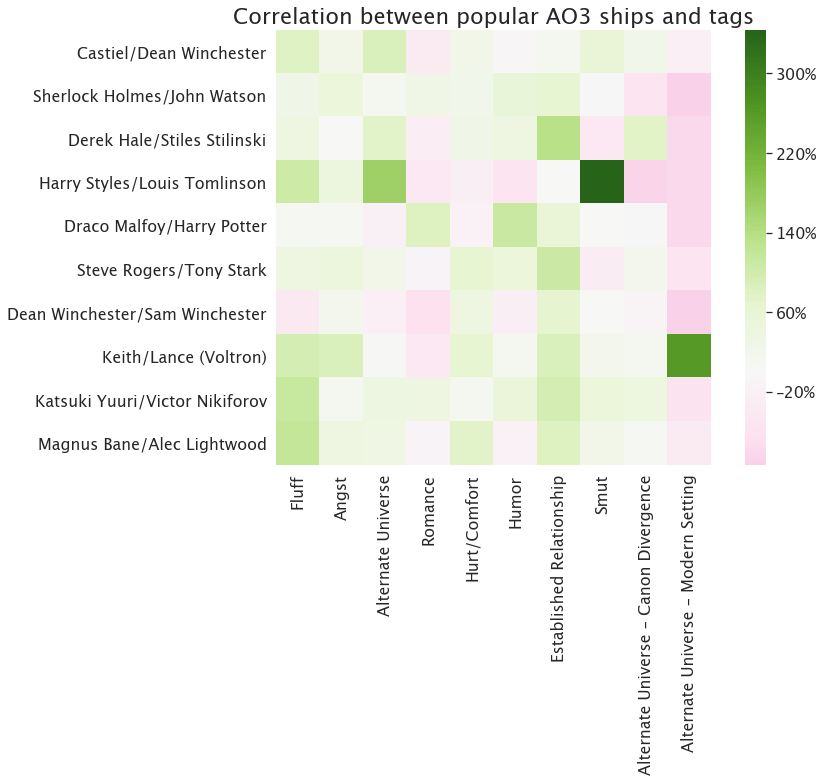

In [12]:
fig, ax = plt.subplots()
tags_index, relationship_tags_index, heat_matrix, norm_heat_matrix = cross_correlate(
    data_top_tags, "TagName", data_top_relationship_tags, "TagName", pivot=True, nworks=nworks)
norm_heat_matrix = reorder_array(norm_heat_matrix, tags_index, top_tags, axis='x')
norm_heat_matrix = reorder_array(norm_heat_matrix, relationship_tags_index, top_relationship_tags, axis='y')
#sns.heatmap(np.log10(norm_heat_matrix), xticklabels=top_tags, yticklabels=top_relationship_tags, ax=ax, center=0, cmap="PiYG")
sns.heatmap((norm_heat_matrix), xticklabels=top_tags, yticklabels=top_relationship_tags, ax=ax, center=1, cmap="PiYG")
ax.set_aspect('equal')
cbar = ax.figure.get_axes()[1]
vals = cbar.get_yticks()
cbar.yaxis.set_ticklabels(['{:,.0%}'.format((x-1)) for x in vals])
ax.set_title("Correlation between popular AO3 ships and tags")
fig.savefig("tags_relationship_tags_crosscorrelation.png")

In [13]:
for pi, this_pairing in enumerate(top_relationship_tags):
    this_data = data_top_relationship_tags.query('TagName == "{}"'.format(this_pairing))
    other_tags_mask = data['ID'].isin(this_data["ID"])
    other_tags = data[other_tags_mask]
    write_dataframe(other_tags['TagName'].value_counts().head(100), 'top_pairing_tags_{}.txt'.format(pi))

Ratings and character tags?

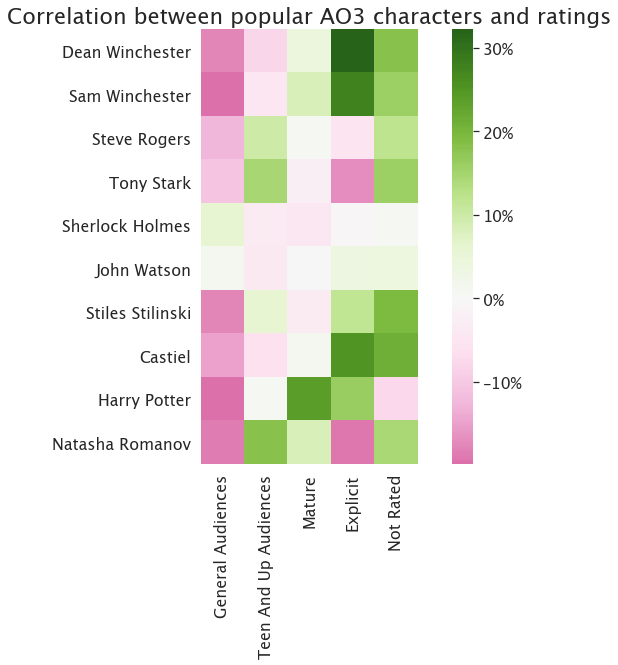

In [14]:
data_top_character_tags = data.loc[data["TagName"].isin(top_character_tags)]

fig, ax = plt.subplots()
ratings_index, tags_index, heat_matrix, norm_heat_matrix = cross_correlate(
    ratings_data, "Rating", data_top_character_tags, "TagName", pivot=True, nworks=nworks)
norm_heat_matrix = reorder_array(norm_heat_matrix, tags_index, top_character_tags, axis='y')
norm_heat_matrix = reorder_array(norm_heat_matrix, ratings_index, new_ratings_index, axis="x")
#sns.heatmap(np.log10(norm_heat_matrix), xticklabels=new_ratings_index, yticklabels=top_character_tags, ax=ax, center=0, cmap="PiYG")
sns.heatmap((norm_heat_matrix), xticklabels=new_ratings_index, yticklabels=top_character_tags, ax=ax, center=1, cmap="PiYG")
ax.set_aspect('equal')
cbar = ax.figure.get_axes()[1]
vals = cbar.get_yticks()
cbar.yaxis.set_ticklabels(['{:,.0%}'.format((x-1)) for x in vals])
ax.set_title("Correlation between popular AO3 characters and ratings")
fig.savefig("ratings_character_tags_crosscorrelation.png")

Character tags and freeform tags?

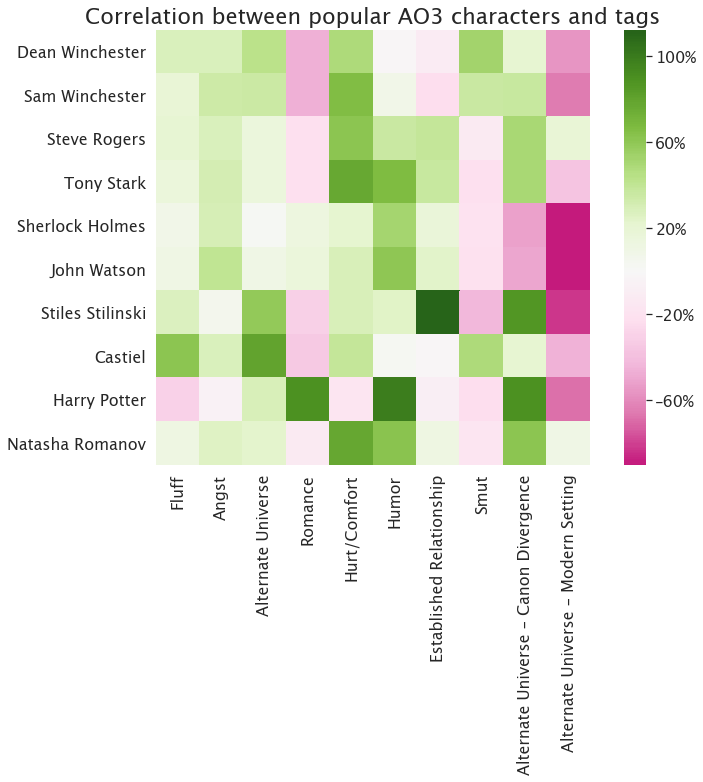

In [16]:
fig, ax = plt.subplots()
tags_index, character_tags_index, heat_matrix, norm_heat_matrix = cross_correlate(
    data_top_tags, "TagName", data_top_character_tags, "TagName", pivot=True, nworks=nworks)
norm_heat_matrix = reorder_array(norm_heat_matrix, tags_index, top_tags, axis='x')
norm_heat_matrix = reorder_array(norm_heat_matrix, character_tags_index, top_character_tags, axis='y')
sns.heatmap((norm_heat_matrix), xticklabels=top_tags, yticklabels=top_character_tags, ax=ax, center=1, cmap="PiYG")
#sns.heatmap(np.log10(norm_heat_matrix), xticklabels=top_tags, yticklabels=top_character_tags, ax=ax, center=0, cmap="PiYG")
ax.set_aspect('equal')
cbar = ax.figure.get_axes()[1]
vals = cbar.get_yticks()
cbar.yaxis.set_ticklabels(['{:,.0%}'.format((x-1)) for x in vals])
ax.set_title("Correlation between popular AO3 characters and tags")
fig.savefig("tags_character_tags_crosscorrelation.png")

In [17]:
for ci, this_character in enumerate(top_character_tags):
    this_data = data_top_character_tags.query('TagName == "{}"'.format(this_character))
    other_tags_mask = data['ID'].isin(this_data["ID"])
    other_tags = data[other_tags_mask]
    write_dataframe(other_tags['TagName'].value_counts().head(100), 'top_character_tags_{}.txt'.format(ci))

Character tags and pairing type?

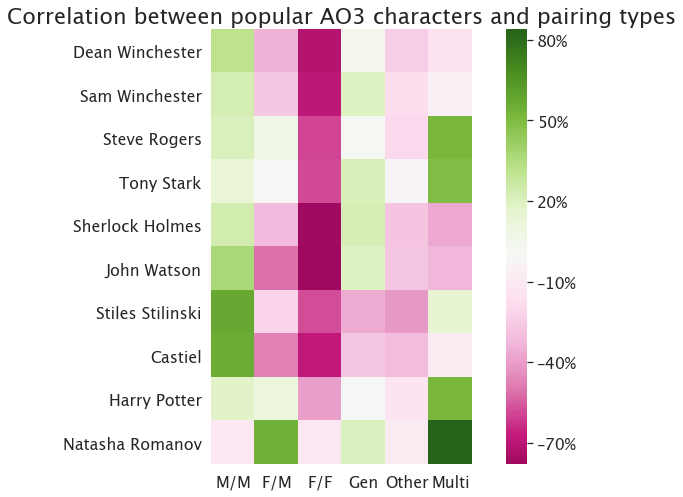

In [18]:
fig, ax = plt.subplots()
pairing_type_index, character_tag_index, heat_matrix, norm_heat_matrix = cross_correlate(
    pairing_data, "PairingType", data_top_character_tags, "TagName", pivot=[False, True], nworks=nworks)
norm_heat_matrix = reorder_array(norm_heat_matrix, character_tag_index, top_character_tags, axis='y')
#sns.heatmap(np.log10(norm_heat_matrix), xticklabels=pairing_type_index, yticklabels=top_character_tags, ax=ax, center=0, cmap='PiYG')
sns.heatmap((norm_heat_matrix), xticklabels=pairing_type_index, yticklabels=top_character_tags, ax=ax, center=1, cmap='PiYG')
ax.set_aspect('equal')
cbar = ax.figure.get_axes()[1]
vals = cbar.get_yticks()
cbar.yaxis.set_ticklabels(['{:,.0%}'.format((x-1)) for x in vals])
ax.set_title("Correlation between popular AO3 characters and pairing types")
fig.savefig("character_tag_pairingtype_crosscorrelation.png")

Fandom and tag cross-correlation?

In [19]:
fandom_data = get_topten_fandoms(db)

fandom_data = fandom_data.sort_values('ReportedNum', ascending=False)
fandom_data_head = fandom_data.head(10)

f_data = db.get_data("ID", "FandomName", 
                     duplicates=False,
                     conditions=["FandomName in ({})".format(', '.join(
                             ['"{}"'.format(f) for f in fandom_data_head['DBFandomName']]
                      ))])


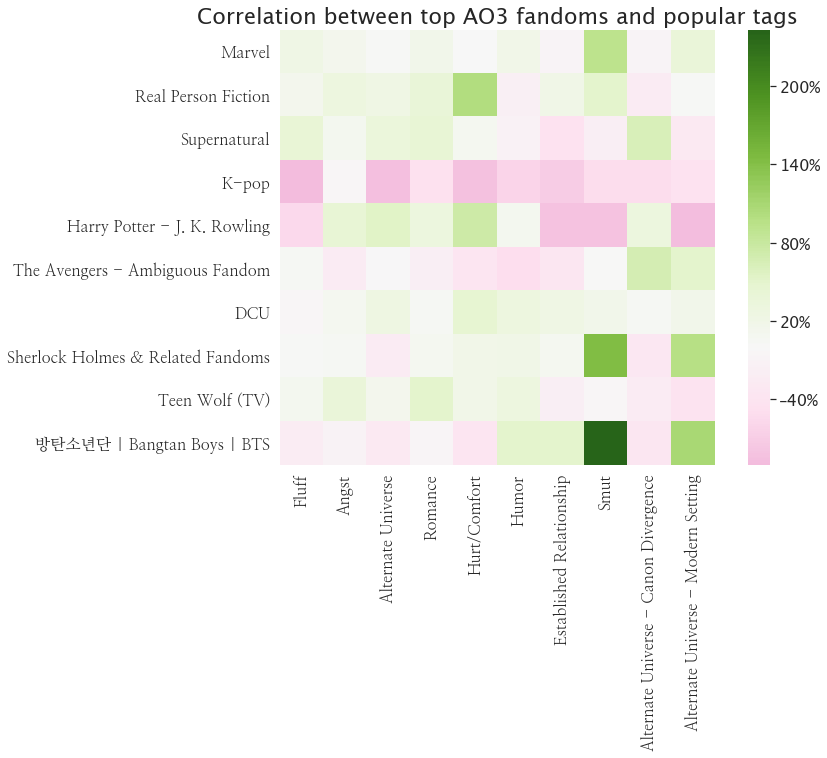

In [20]:
fandom_index, tag_index, heat_matrix, norm_heat_matrix = cross_correlate(
    f_data, "FandomName", data_top_tags, "TagName", pivot=True, nworks=nworks)
fig, ax = plt.subplots()
#print fandom_index, 
norm_heat_matrix = reorder_array(norm_heat_matrix, tags_index, top_tags, axis='x')
norm_heat_matrix = reorder_array(norm_heat_matrix, fandom_index, fandom_data_head['DBFandomName'], axis='y')
#sns.heatmap(np.log10(norm_heat_matrix), xticklabels=top_tags, yticklabels=fandom_data_head['FandomName'], ax=ax, center=0, cmap="PiYG")
sns.heatmap((norm_heat_matrix), xticklabels=top_tags, yticklabels=fandom_data_head['FandomName'], ax=ax, center=1, cmap="PiYG")
ax.set_aspect('equal')
labels = ax.get_yticklabels()
for label in labels:
    label.set_fontname('NanumMyeongjo')
ax.set_yticklabels(labels)
labels = ax.get_xticklabels()
for label in labels:
    label.set_fontname('NanumMyeongjo')
ax.set_xticklabels(labels)
cbar = ax.figure.get_axes()[1]
vals = cbar.get_yticks()
cbar.yaxis.set_ticklabels(['{:,.0%}'.format((x-1)) for x in vals])
ax.set_title("Correlation between top AO3 fandoms and popular tags")
fig.savefig("fandom_tags_crosscorrelation.png")

In [21]:
for fi, fandom in enumerate(fandom_data_head['DBFandomName']):
    this_data = f_data.query('FandomName == "{}"'.format(fandom))
    other_tags_mask = data['ID'].isin(this_data["ID"])
    other_tags = data[other_tags_mask]
    write_dataframe(other_tags['TagName'].value_counts().head(100), 'top_fandom_all_tags_{}.txt'.format(fi))
    other_tags = data[other_tags_mask]
    other_tags = other_tags[other_tags["TagName"].isin(freeform['TagName'])]
    write_dataframe(other_tags['TagName'].value_counts().head(100), 'top_fandom_freeform_tags_{}.txt'.format(fi))

Finally, let's make a network graph of the different tags, and figure out some blocks for them.

In [22]:
data_plot_tags = data.loc[data["TagName"].isin(plot_top_tags)]

tag_index, heat_matrix, weights = correlate(data_plot_tags, 'TagName', nworks=nworks)
weights = reorder_array(weights, tag_index, plot_top_tags)

In [23]:
size_list = [freeform_tag_counts[tag] for tag in plot_top_tags]

edge_list = []
for i, key1 in enumerate(plot_top_tags):
    for j, key2 in enumerate(plot_top_tags):
        # Lazy triangle
        if j <= i or weights[i][j]==0:
            continue
        edge_list.append((i, j, weights[i][j]))

In [24]:
g = gt.Graph(directed=False)
g.add_vertex(len(size_list))
weights = g.new_edge_property('float')
g.add_edge_list(edge_list, eprops = [weights])

In [25]:
blocklist = []
entropylist = []
for i in range(7):
    print("Working on", i)
    # The weights are supposed to be one of five types. This isn't exactly 'real-exponential'
    # but it's closer than any of the other options--it doesn't seem to perform too badly, anyway.
    blocks = gt.minimize_blockmodel_dl(g, state_args=dict(recs=[weights], rec_types=['real-exponential']))
    blocklist.append(blocks)
    entropylist.append(blocks.entropy())
blocks = blocklist[np.argmin(entropylist)]

Working on 0
Working on 1
Working on 2
Working on 3
Working on 4
Working on 5
Working on 6


In [26]:
# Find optimal vertex positions from graph-tool
pos = gt.sfdp_layout(g, eweight=weights)

In [27]:
# Make some layouts for plotly graph
Xn=[p[0] for p in pos] 
Yn=[p[1] for p in pos]
    
set_weights = set([e[2] for e in edge_list])
list_Xe = []
list_Ye = []
list_W = []
for w in set_weights:
    # Using w directly made the plot more crowded; this is easier to read
    list_W.append(np.sqrt(w))
    Xe=[]
    Ye=[]
    for edge in edge_list:
        if edge[2] == w:
            Xe += [Xn[edge[0]], Xn[edge[1]], None]
            Ye += [Yn[edge[0]], Yn[edge[1]], None]
    list_Xe.append(Xe)
    list_Ye.append(Ye)

In [28]:
# Turn this into objects for plotly to display
trace_list = []
for Xe, Ye, w in zip(list_Xe, list_Ye, list_W):
    trace_list.append(
        go.Scatter(x=Xe, y=Ye,mode='lines',
                   line=dict(color='rgb(125,125,125)', width=0.1*w),
                   hoverinfo='none')
        )

size_list = np.array(size_list)
size_list = 10 + 50*(size_list - np.min(size_list))/(np.max(size_list)-np.min(size_list))
    
trace_list.append(
    go.Scatter(x=Xn, y=Yn,
               mode='markers', name='actors',
               marker=dict(symbol='circle', size=size_list,
                           color=list(blocks.get_blocks()), colorscale='YlGnBu',
                           line=dict(color='rgb(50,50,50)', width=0.5)
                           ),
               text=list(plot_top_tags_pretty), hoverinfo='text')
    )

axis=dict(autorange=True,
          showgrid=False,
          zeroline=False,
          showline=False,
          ticks='',
          showticklabels=False)


layout = go.Layout(
             title='Top AO3 tags and their connections',
             width=1000, height=1000, showlegend=False,
             xaxis=axis, yaxis=axis,
             margin=dict(t=100),
             hovermode='closest')

In [29]:
fig=go.Figure(data=trace_list, layout=layout)

plot_html = py.plot(fig, filename='ao3_tag_graph', include_plotlyjs=False, output_type='div')
plot_html = '<script src="https://cdn.plot.ly/plotly-latest.min.js"></script>'+plot_html
with open('interactive_plot_code.txt', 'w') as f:
    f.write(plot_html)


In [30]:
with open('tag_blocklist.txt', 'w') as f:
    for i in range(blocks.get_B()):
        these_tags = [tag for tag, block_idx in zip(plot_top_tags_pretty, blocks.get_blocks()) if block_idx==i]
        these_tags.sort()
        f.write('{}: {}\n'.format(i, ', '.join(these_tags)))